# Quickstart Guide

In [1]:
import numpy as np
from jax import numpy as jnp, random
from jax.numpy.linalg import cholesky, inv
from jax.scipy.special import logsumexp
import mombf
import matplotlib.pyplot as plt
import pandas as pd

key = random.PRNGKey(0)
key, subkey = random.split(key)

/home/oriol/venvs/jax/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def get_corr_data(p, x, corr_mat=None, key=None):
    n = len(x)
    if key is None:
        key = random.PRNGKey(0)
    key, subkey = random.split(key)        
    if corr_mat is None:
        corr_mat = (jnp.ones((p, p)) + jnp.eye(p)) / 2
    x_extra = random.normal(subkey, (n, p-1))
    x_all = jnp.hstack((x.reshape((-1,1)), x_extra))
    
    c1 = jnp.cov(x_all, rowvar=False)
    c1 += 1e-8 * jnp.eye(p)
    
    chol1 = inv(cholesky(c1).T)
    newx =  jnp.dot(x_all, chol1)
    
    chol2 = cholesky(corr_mat).T

    finalx = jnp.dot(newx, chol2) * jnp.std(x) + jnp.mean(x)
    return finalx    

def get_result_df(models, model_probs):
    order = np.argsort(np.array(model_probs))[::-1]
    logprob = modprobs[order] - modprobs[order[0]]
    exp_ = np.exp(logprob)
    df = pd.DataFrame({"model_idx": modidxs[order], "modprob": exp_/np.sum(exp_)}).set_index("model_idx")
    return df

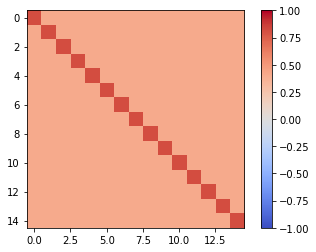

In [3]:
n = 200
p = 15
x = random.normal(key, (n,))
X = get_corr_data(p, x)
plt.imshow(jnp.cov(X, rowvar=False), cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [4]:
y = ((1.1 * X[:, 1] - .9 * X[:, 2] + random.normal(subkey, (n,))) > 0).astype(jnp.int32)
fmt = f"{{:0{p}b}}"
gammes = np.array([list(fmt.format(i)) for i in range(2 ** p)])
gammes = jnp.array(gammes == "0")[:-1,:]

aux = np.where(gammes, np.array([f"{i}," for i in range(p)]), "")
modidxs = np.apply_along_axis(lambda x: "".join(x).strip(","), 1, aux)

In [5]:
_, modprobs = mombf.modelSelection(X, y, gammes, family="logistic", prior="mom", method="post")

In [6]:
df = get_result_df(modidxs, modprobs)
df.head(7)

,modprob
model_idx,
"1,2,12",0.032663
"1,2,9,12",0.025090
"1,2",0.021957
"1,2,11,12",0.010172
"1,2,9,10,12",0.009415
"1,2,10",0.009091
"1,2,10,12",0.008659


In [7]:
_, modprobs = mombf.modelSelection(X, y, gammes, family="logistic", prior="normal", method="post")

In [8]:
df = get_result_df(modidxs, modprobs)
df.head(7)

,modprob
model_idx,
"1,2,12",0.033522
"1,2,9,12",0.025452
"1,2",0.022789
"1,2,11,12",0.010321
"1,2,9,10,12",0.009438
"1,2,10",0.009331
"1,2,10,12",0.008783


In [5]:
_, modprobs = mombf.modelSelection(X, y, gammes, family="logistic", prior="momlog", method="post")

In [6]:
df = get_result_df(modidxs, modprobs)
df.head(7)

,modprob
model_idx,
"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14",1.0
"0,1,2,3,4,5,6,8,9,10,11,12,13,14",0.0
"0,1,2,3,5,6,7,8,9,10,11,12,13,14",0.0
"0,1,2,3,4,5,6,7,8,9,10,11,12,14",0.0
"0,1,2,3,4,5,6,7,8,9,11,12,13,14",0.0
"0,1,2,3,4,5,6,7,8,10,11,12,13,14",0.0
"0,1,2,3,4,5,6,7,8,9,10,11,13,14",0.0


In [ ]:
#%timeit mombf.modelSelection(X, y, gammes, family="logistic", prior="mom", method="lik")